In [1]:
%matplotlib inline

In [2]:
import os
from pyspark import SparkConf, SparkContext
from hail import *
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from collections import Counter
from math import log, isnan
from pprint import pprint

In [17]:
!sparkcluster start \
--walltime ##:##  \
--queue NAME \
--memory-per-core #### \
--cores-per-executor ## \
##

INFO:sparkhpc.sparkjob:Submitted batch job 7302

INFO:sparkhpc.sparkjob:Submitted cluster 0


In [6]:
os.environ['SPARK_MASTER_URL'] = 'PATH'

In [9]:
sc = SparkContext(conf=SparkConf().setAll([
   (u'spark.sql.files.maxPartitionBytes', u'#########'),
   (u'spark.sql.files.openCostInBytes', u'#########'),
   (u'spark.app.name', u'HAIL'),
   (u'spark.master', os.environ['SPARK_MASTER_URL']),
   (u'spark.submit.deployMode', '####'),
   (u'spark.driver.maxResultSize', '##'),
   (u'spark.executor.instances', '##')

    ]))

In [3]:
#start the Hail context
hc = HailContext()

Running on Apache Spark version 2.1.1
SparkUI available at http://172.26.8.132:4041
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.1-5306854


In [4]:
#load data from disk
vds = hc.read('/PATH/TO/gnomAD.vds')

In [5]:
vtable = vds.variants_table()

In [7]:
#look at the structure of the table using "schema"
pprint(vtable.schema)

Struct{
     v: Variant,
     va: Struct{
         rsid: String,
         qual: Double,
         filters: Set[String],
         info: Struct{
             AC: Array[Int],
             AF: Array[Double],
             AN: Int,
             BaseQRankSum: Double,
             ClippingRankSum: Double,
             DB: Boolean,
             DP: Int,
             FS: Double,
             InbreedingCoeff: Double,
             MQ: Double,
             MQRankSum: Double,
             QD: Double,
             ReadPosRankSum: Double,
             SOR: Double,
             VQSLOD: Double,
             VQSR_culprit: String,
             VQSR_NEGATIVE_TRAIN_SITE: Boolean,
             VQSR_POSITIVE_TRAIN_SITE: Boolean,
             GQ_HIST_ALT: Array[String],
             DP_HIST_ALT: Array[String],
             AB_HIST_ALT: Array[String],
             GQ_HIST_ALL: String,
             DP_HIST_ALL: String,
             AB_HIST_ALL: String,
             AC_AFR: Array[Int],
             AC_AMR: Array[I

In [14]:
#split multi-allelic variants
vds = vds.split_multi()

In [ ]:
#map the variants to their alternate allele, filter to SNPs, and count by unique ref/alt pair
snp_counts = vds.query_variants('variants.map(v => v.altAllele()).filter(aa => aa.isSNP()).counter()')
pprint(Counter(snp_counts).most_common())

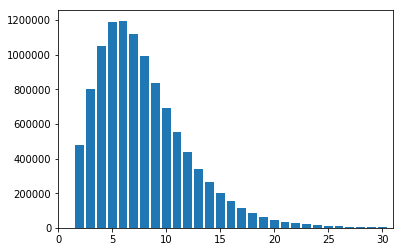

In [20]:
#Here we will use the hist aggregator to produce and plot a histogram of DP values for genotypes in our thousand genomes dataset.
dp_hist = vds.query_genotypes('gs.map(g => g.dp).hist(0, 30, 30)')
plt.xlim(0, 31)
plt.bar(dp_hist.binEdges[1:], dp_hist.binFrequencies)
plt.show()

In [21]:
#QC is entirely based on the ability to understand the properties of a dataset. 
#Hail attempts to make this easier by providing the sample_qc method, which produces a set of 
#useful metrics as sample annotations.
pprint(vds.sample_schema)

Struct{
     Population: String,
     SuperPopulation: String,
     isFemale: Boolean,
     PurpleHair: Boolean,
     CaffeineConsumption: Int
 }


In [22]:
vds = vds.sample_qc()

In [23]:
pprint(vds.sample_schema)

Struct{
     Population: String,
     SuperPopulation: String,
     isFemale: Boolean,
     PurpleHair: Boolean,
     CaffeineConsumption: Int,
     qc: Struct{
         callRate: Double,
         nCalled: Int,
         nNotCalled: Int,
         nHomRef: Int,
         nHet: Int,
         nHomVar: Int,
         nSNP: Int,
         nInsertion: Int,
         nDeletion: Int,
         nSingleton: Int,
         nTransition: Int,
         nTransversion: Int,
         dpMean: Double,
         dpStDev: Double,
         gqMean: Double,
         gqStDev: Double,
         nNonRef: Int,
         rTiTv: Double,
         rHetHomVar: Double,
         rInsertionDeletion: Double
     }
 }


In [24]:
#We can pull out these new metrics to a Pandas dataframe with one line of code:
df = vds.samples_table().to_pandas()

In [25]:
#Peek at the data
df.head()


,s,sa.Population,sa.SuperPopulation,sa.isFemale,sa.PurpleHair,sa.CaffeineConsumption,sa.qc.callRate,sa.qc.nCalled,sa.qc.nNotCalled,sa.qc.nHomRef,...,sa.qc.nTransition,sa.qc.nTransversion,sa.qc.dpMean,sa.qc.dpStDev,sa.qc.gqMean,sa.qc.gqStDev,sa.qc.nNonRef,sa.qc.rTiTv,sa.qc.rHetHomVar,sa.qc.rInsertionDeletion
0,HG00096,GBR,EUR,False,False,6,0.979017,10731,230,6321,...,5233,1190,4.566828,2.343927,22.506570,22.531111,4410,4.397479,1.190760,None
1,HG00097,GBR,EUR,True,True,6,0.993705,10892,69,6152,...,5279,1251,9.440750,3.653101,42.334833,28.494689,4740,4.219824,1.648045,None
2,HG00099,GBR,EUR,True,False,6,0.988687,10837,124,6113,...,5377,1229,8.240004,3.720313,37.523761,28.130359,4724,4.375102,1.510096,None
3,HG00100,GBR,EUR,True,False,6,0.999909,10960,1,6088,...,5400,1238,12.756478,3.912233,52.740967,27.669909,4872,4.361874,1.758777,None
4,HG00101,GBR,EUR,False,True,8,0.995347,10910,51,6229,...,5358,1212,6.573118,2.887462,30.568286,25.611360,4681,4.420792,1.478031,None


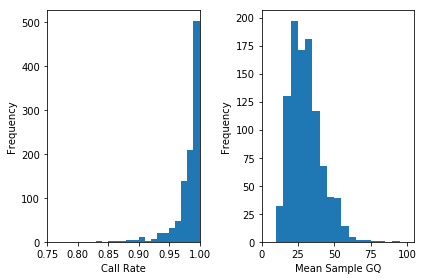

In [26]:
#Plot QC metrics
plt.clf()
plt.subplot(1, 2, 1)
plt.hist(df["sa.qc.callRate"], bins=np.arange(.75, 1.01, .01))
plt.xlabel("Call Rate")
plt.ylabel("Frequency")
plt.xlim(.75, 1)

plt.subplot(1, 2, 2)
plt.hist(df["sa.qc.gqMean"], bins = np.arange(0, 105, 5))
plt.xlabel("Mean Sample GQ")
plt.ylabel("Frequency")
plt.xlim(0, 105)

plt.tight_layout()
plt.show()

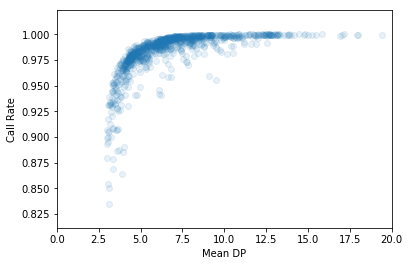

In [27]:
#these metrics are correlated: call rate and mean DP
plt.scatter(df["sa.qc.dpMean"], df["sa.qc.callRate"],
            alpha=0.1)
plt.xlabel('Mean DP')
plt.ylabel('Call Rate')
plt.xlim(0, 20)
plt.show()

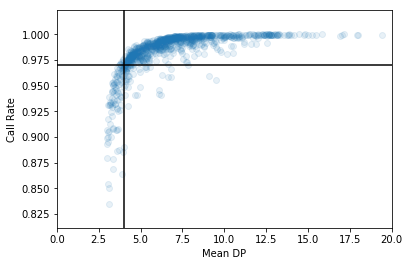

In [28]:
#Removing outliers from the dataset will generally improve association results. 
#We can draw lines on the above plot to indicate outlier cuts. 
#We’ll want to remove all samples that fall in the bottom left quadrant.
plt.scatter(df["sa.qc.dpMean"], df["sa.qc.callRate"],
            alpha=0.1)
plt.xlabel('Mean DP')
plt.ylabel('Call Rate')
plt.xlim(0, 20)
plt.axhline(0.97, c='k')
plt.axvline(4, c='k')
plt.show()

In [29]:
#Filtering is simpler when use these cutoff values:
vds = vds.filter_samples_expr('sa.qc.dpMean >= 4 && sa.qc.callRate >= 0.97')
print('After filter, %d/1000 samples remain.' % vds.num_samples)

After filter, 843/1000 samples remain.


In [ ]:
#Next is genotype QC. To start, we’ll print the post-sample-QC call rate. It’s 
#increased since the initial summary - dropping low-quality samples disproportionally removed missing genotypes.
call_rate = vds.query_genotypes('gs.fraction(g => g.isCalled)')
print('pre QC call rate is %.3f' % call_rate)

In [31]:
#It’s a good idea to filter out genotypes where the reads aren’t where they should be: if we find 
#a genotype called homozygous reference with >10% alternate reads, a genotype called 
#homozygous alternate with >10% reference reads, 
#or a genotype called heterozygote without a ref / alt balance near 1:1, it is likely to be an error.
filter_condition_ab = '''let ab = g.ad[1] / g.ad.sum() in
                         ((g.isHomRef && ab <= 0.1) ||
                          (g.isHet && ab >= 0.25 && ab <= 0.75) ||
                          (g.isHomVar && ab >= 0.9))'''
vds = vds.filter_genotypes(filter_condition_ab)

In [32]:
post_qc_call_rate = vds.query_genotypes('gs.fraction(g => g.isCalled)')
print('post QC call rate is %.3f' % post_qc_call_rate)

post QC call rate is 0.955


In [33]:
#Variant QC is a bit more of the same: we can use the 
#variant_qc method to produce a variety of useful statistics, plot them, and filter.
pprint(vds.variant_schema)

Struct{
     rsid: String,
     qual: Double,
     filters: Set[String],
     pass: Boolean,
     info: Struct{
         AC: Array[Int],
         AF: Array[Double],
         AN: Int,
         BaseQRankSum: Double,
         ClippingRankSum: Double,
         DP: Int,
         DS: Boolean,
         FS: Double,
         HaplotypeScore: Double,
         InbreedingCoeff: Double,
         MLEAC: Array[Int],
         MLEAF: Array[Double],
         MQ: Double,
         MQ0: Int,
         MQRankSum: Double,
         QD: Double,
         ReadPosRankSum: Double,
         set: String
     }
 }


In [34]:
#The cache (Hail's version of persist) is used to optimize some of the downstream operations
vds = vds.variant_qc().cache()

In [35]:
pprint(vds.variant_schema)

Struct{
     rsid: String,
     qual: Double,
     filters: Set[String],
     pass: Boolean,
     info: Struct{
         AC: Array[Int],
         AF: Array[Double],
         AN: Int,
         BaseQRankSum: Double,
         ClippingRankSum: Double,
         DP: Int,
         DS: Boolean,
         FS: Double,
         HaplotypeScore: Double,
         InbreedingCoeff: Double,
         MLEAC: Array[Int],
         MLEAF: Array[Double],
         MQ: Double,
         MQ0: Int,
         MQRankSum: Double,
         QD: Double,
         ReadPosRankSum: Double,
         set: String
     },
     qc: Struct{
         callRate: Double,
         AC: Int,
         AF: Double,
         nCalled: Int,
         nNotCalled: Int,
         nHomRef: Int,
         nHet: Int,
         nHomVar: Int,
         dpMean: Double,
         dpStDev: Double,
         gqMean: Double,
         gqStDev: Double,
         nNonRef: Int,
         rHeterozygosity: Double,
         rHetHomVar: Double,
         rExpectedHetFrequen

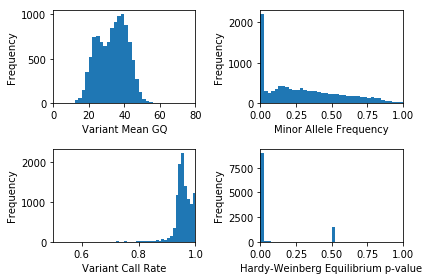

In [36]:
variant_df = vds.variants_table().to_pandas()

plt.clf()
plt.subplot(2, 2, 1)
variantgq_means = variant_df["va.qc.gqMean"]
plt.hist(variantgq_means, bins = np.arange(0, 84, 2))
plt.xlabel("Variant Mean GQ")
plt.ylabel("Frequency")
plt.xlim(0, 80)

plt.subplot(2, 2, 2)
variant_mleaf = variant_df["va.qc.AF"]
plt.hist(variant_mleaf, bins = np.arange(0, 1.05, .025))
plt.xlabel("Minor Allele Frequency")
plt.ylabel("Frequency")
plt.xlim(0, 1)

plt.subplot(2, 2, 3)
plt.hist(variant_df['va.qc.callRate'], bins = np.arange(0, 1.05, .01))
plt.xlabel("Variant Call Rate")
plt.ylabel("Frequency")
plt.xlim(.5, 1)

plt.subplot(2, 2, 4)
plt.hist(variant_df['va.qc.pHWE'], bins = np.arange(0, 1.05, .025))
plt.xlabel("Hardy-Weinberg Equilibrium p-value")
plt.ylabel("Frequency")
plt.xlim(0, 1)

plt.tight_layout()
plt.show()

In [37]:
#Let’s do a GWAS!
#First, we need to restrict to variants that are:

# 1) common (we’ll use a cutoff of 1%)
# 2) uncorrelated (not in linkage disequilibrium)

common_vds = (vds
              .filter_variants_expr('va.qc.AF > 0.01')
              .ld_prune(memory_per_core=256, num_cores=4))

2017-12-20 11:18:40 Hail: INFO: Running LD prune with nSamples=843, nVariants=9085, nPartitions=4, and maxQueueSize=257123.
2017-12-20 11:18:40 Hail: INFO: LD prune step 1 of 3: nVariantsKept=8478, nPartitions=4, time=378.749ms
2017-12-20 11:18:41 Hail: INFO: LD prune step 2 of 3: nVariantsKept=8478, nPartitions=12, time=1.160s
2017-12-20 11:18:41 Hail: INFO: Coerced sorted dataset
2017-12-20 11:18:42 Hail: INFO: LD prune step 3 of 3: nVariantsKept=8478, time=429.164ms


In [38]:
common_vds.count()

(843L, 8555L)

In [39]:
#These filters removed about 15% of sites (we started with a bit over 10,000). 
#This is NOT representative of most sequencing datasets! 
#We have already downsampled the full thousand genomes dataset to 
#include more common variants than we’d expect by chance.
#In Hail, the association tests accept sample annotations for the sample phenotype and covariates. 
#Since we’ve already got our phenotype of interest (caffeine consumption) in the dataset, we are good to go:
gwas = common_vds.linreg('sa.CaffeineConsumption')
pprint(gwas.variant_schema)

2017-12-20 11:18:42 Hail: INFO: Running linear regression on 843 samples with 1 covariate including intercept...


Struct{
     rsid: String,
     qual: Double,
     filters: Set[String],
     pass: Boolean,
     info: Struct{
         AC: Array[Int],
         AF: Array[Double],
         AN: Int,
         BaseQRankSum: Double,
         ClippingRankSum: Double,
         DP: Int,
         DS: Boolean,
         FS: Double,
         HaplotypeScore: Double,
         InbreedingCoeff: Double,
         MLEAC: Array[Int],
         MLEAF: Array[Double],
         MQ: Double,
         MQ0: Int,
         MQRankSum: Double,
         QD: Double,
         ReadPosRankSum: Double,
         set: String
     },
     qc: Struct{
         callRate: Double,
         AC: Int,
         AF: Double,
         nCalled: Int,
         nNotCalled: Int,
         nHomRef: Int,
         nHet: Int,
         nHomVar: Int,
         dpMean: Double,
         dpStDev: Double,
         gqMean: Double,
         gqStDev: Double,
         nNonRef: Int,
         rHeterozygosity: Double,
         rHetHomVar: Double,
         rExpectedHetFrequen

In [40]:
#Looking at the bottom of the above printout, you can see the linear regression adds 
#new variant annotations for the beta, standard error, t-statistic, and p-value.
def qqplot(pvals, xMax, yMax):
    spvals = sorted(filter(lambda x: x and not(isnan(x)), pvals))
    exp = [-log(float(i) / len(spvals), 10) for i in np.arange(1, len(spvals) + 1, 1)]
    obs = [-log(p, 10) for p in spvals]
    plt.clf()
    plt.scatter(exp, obs)
    plt.plot(np.arange(0, max(xMax, yMax)), c="red")
    plt.xlabel("Expected p-value (-log10 scale)")
    plt.ylabel("Observed p-value (-log10 scale)")
    plt.xlim(0, xMax)
    plt.ylim(0, yMax)
    plt.show()

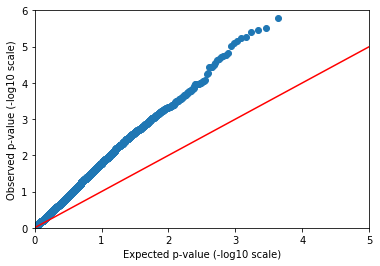

In [41]:
#make a Q-Q (quantile-quantile) plot.
qqplot(gwas.query_variants('variants.map(v => va.linreg.pval).collect()'),
       5, 6)

In [42]:
#The observed p-values drift away from the expectation immediately. 
#Either every SNP in our dataset is causally linked to caffeine consumption (unlikely), or there’s a confounder.
#Sample ancestry was actually used to simulate this phenotype. 
#This leads to a stratified distribution of the phenotype. 
#The solution is to include ancestry as a covariate in our regression.
#The linreg method can also take sample annotations to use as covariates. 
#We already annotated our samples with reported ancestry, 
#but it is good to be skeptical of these labels due to human error. 
#Genomes don’t have that problem! 
#Instead of using reported ancestry, 
#we will use genetic ancestry by including computed principal components in our model.
#The pca method produces sample PCs in sample annotations, and can also produce variant loadings and global eigenvalues when asked.

pca = common_vds.pca('sa.pca', k=5, eigenvalues='global.eigen')

2017-12-20 11:18:47 Hail: INFO: Running PCA with 5 components...


In [43]:
pprint(pca.globals)

{u'eigen': {u'PC1': 56.34707905481801,
            u'PC2': 37.81090030103982,
            u'PC3': 16.91974301822238,
            u'PC4': 2.707349935634391,
            u'PC5': 2.0851252187821228}}


In [ ]:
pprint(pca.sample_schema)

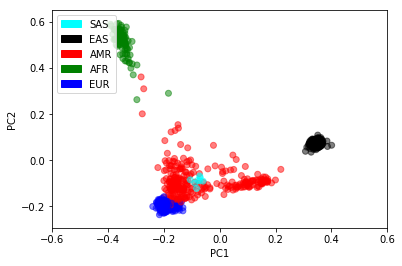

In [45]:
#Now that we’ve got principal components per sample, we may as well plot them! 
#Human history exerts a strong effect in genetic datasets. 
#Even with a 50MB sequencing dataset, we can recover the major human populations.
pca_table = pca.samples_table().to_pandas()
colors = {'AFR': 'green', 'AMR': 'red', 'EAS': 'black', 'EUR': 'blue', 'SAS': 'cyan'}
plt.scatter(pca_table["sa.pca.PC1"], pca_table["sa.pca.PC2"],
            c = pca_table["sa.SuperPopulation"].map(colors),
            alpha = .5)
plt.xlim(-0.6, 0.6)
plt.xlabel("PC1")
plt.ylabel("PC2")
legend_entries = [mpatches.Patch(color=c, label=pheno) for pheno, c in colors.items()]
plt.legend(handles=legend_entries, loc=2)
plt.show()

In [ ]:
#Now we can rerun our linear regression, controlling for the first few principal components and sample sex.
pvals = (common_vds
        .annotate_samples_table(pca.samples_table(), expr='sa.pca = table.pca')
        .linreg('sa.CaffeineConsumption', covariates=['sa.pca.PC1', 'sa.pca.PC2', 'sa.pca.PC3', 'sa.isFemale'])
        .query_variants('variants.map(v => va.linreg.pval).collect()'))

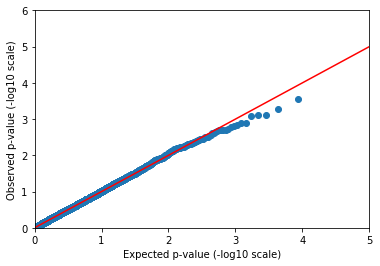

In [47]:
qqplot(pvals, 5, 6)

In [ ]:
pvals = (common_vds
        .annotate_samples_table(pca.samples_table(), expr='sa.pca = table.pca')
        .linreg('sa.CaffeineConsumption',
                covariates=['sa.pca.PC1', 'sa.pca.PC2', 'sa.pca.PC3', 'sa.isFemale'],
                use_dosages=True)
        .query_variants('variants.map(v => va.linreg.pval).collect()'))

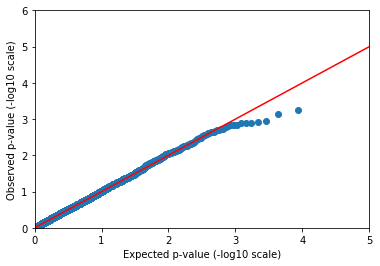

In [49]:
qqplot(pvals, 5, 6)

In [50]:
#Rare variant analysis
#Hail doesn’t yet have rare variant kernel-based methods, but we have linear and logistic burden tests.
#But, one can use the expression language to group and count by any arbitrary properties in variant 
#or sample annotations.


kt = (vds.genotypes_table()
         .aggregate_by_key(key_expr=['pop = sa.SuperPopulation', 'chromosome = v.contig'],
                           agg_expr=['n_het = g.filter(g => g.isHet()).count()']))

In [51]:
kt.to_dataframe().show()

+---+----------+-----+
|pop|chromosome|n_het|
+---+----------+-----+
|EUR|        14|16380|
|SAS|        17|  511|
|EUR|         5|30717|
|AFR|         7|11889|
|EAS|         9|23951|
|AFR|        21| 3529|
|EAS|         X| 7403|
|EAS|         1|49375|
|EUR|        19|13483|
|AMR|        15|18935|
|AMR|         7|31527|
|EUR|        13|17321|
|EUR|        12|26134|
|EUR|        15|15807|
|EUR|         6|33910|
|EAS|        20|17466|
|SAS|        11|  901|
|AFR|         3|15829|
|EAS|         2|45384|
|AMR|        18|18982|
+---+----------+-----+
only showing top 20 rows



In [52]:
kt2 = (vds.genotypes_table()
          .aggregate_by_key(key_expr=['''maf_bin = if (va.qc.AF < 0.01) "< 1%"
                                                   else if (va.qc.AF < 0.05) "1%-5%"
                                                   else "> 5%" ''',
                                     'purple_hair = sa.PurpleHair'],
                           agg_expr=['mean_gq = g.map(g => g.gq).stats().mean',
                                     'mean_dp = g.map(g => g.dp).stats().mean']))

In [53]:
kt2.to_dataframe().show()

+-------+-----------+------------------+-----------------+
|maf_bin|purple_hair|           mean_gq|          mean_dp|
+-------+-----------+------------------+-----------------+
|   > 5%|       true| 36.09305651197578|7.407450459057423|
|   < 1%|       true| 22.68197887434976|7.374254453728496|
|   < 1%|      false|22.986128698357074|7.492131714314245|
|   > 5%|      false|36.341259980753755|7.533399982371768|
|  1%-5%|       true|24.093123033233528|7.269552536649012|
|  1%-5%|      false|  24.3519587208908|7.405582424428774|
+-------+-----------+------------------+-----------------+



In [ ]:
#stop Hail context
hc.stop()

In [ ]:
#stop Spark context
sc.stop()

In [11]:
!sparkcluster stop 0

INFO:sparkhpc.sparkjob:
